# My-Fashion-MNIST-Experiments

In this notebook, I will design my own CNN architecture for classifying the Fashion-MNIST dataset, and will write functions such that I can experiment with different hyperparameters and loss functions/optimizers. LESHGOOOO

Note that just for loading the data in, I will use pre-existing code from [this tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html), which I also used in my `fashion-mnist.ipynb` notebook.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F 

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [3]:
train_data = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

In [36]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [4]:
# experiment - play with the number of batches I want
# default is 4
batch_size = 5

In [5]:
# Create data loaders for our datasets; shuffle for training, not for test
training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [6]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(train_data)))
print('Testing set has {} instances'.format(len(test_data)))

Training set has 60000 instances
Testing set has 10000 instances


Sneaker  Ankle Boot  Ankle Boot  Pullover  Sneaker


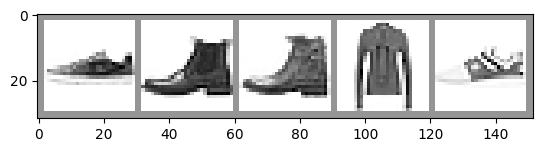

In [7]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(batch_size)))

In [8]:
len(train_data)

60000

In [9]:
train_sample, train_label = train_data[0]
train_sample.shape

torch.Size([1, 28, 28])

## Defining Model Architecture

Let's go for 3 convolutions, 4 fully-connected layers, options for activation (ReLU, sigmoid, tanh), and options for pooling (max, avg). This also gives me a great chance to 1. test out different model architectures, and 2. to test out the limits of my machine (MacBook Pro M3).

In [16]:
def cnn_dims(input_matrix_size, kernel_size):
    output_size_n = input_matrix_size - kernel_size + 1
    print(f'Input matrix size: {input_matrix_size}x{input_matrix_size}')
    print(f'Kernel size: {kernel_size}x{kernel_size}')
    print(f'Therefore output convolved matrix size: {output_size_n}x{output_size_n}')
    return output_size_n

def pooling_dims(input_matrix_size, kernel_size, stride):
    output_size_n = int(np.floor((input_matrix_size - kernel_size) / stride) + 1)
    print(f'Input matrix size: {input_matrix_size}x{input_matrix_size}')
    print(f'Kernel size: {kernel_size}x{kernel_size} + stride: {stride}')
    print(f'Therefore output pooled matrix size: {output_size_n}x{output_size_n}')
    return output_size_n

Input matrix size: 28x28
Kernel size: 5x5
Therefore output convolved matrix size: 24x24


24

In [28]:
conv_kernel_size = 2
pool_kernel_size = 2
pool_stride = 2

print("First convolutional block")
conv1_output = cnn_dims(28, conv_kernel_size)
print("")
pool1_output = pooling_dims(conv1_output, pool_kernel_size, pool_stride)
print("------")
print("Second convolutional block")
conv2_output = cnn_dims(pool1_output, conv_kernel_size)
print("")
pool2_output = pooling_dims(conv2_output, pool_kernel_size, pool_stride)
print("------")
print("Third convolutional block")
conv3_output = cnn_dims(pool2_output, conv_kernel_size)
print("")
pool3_output = pooling_dims(conv3_output, pool_kernel_size, pool_stride)

First convolutional block
Input matrix size: 28x28
Kernel size: 2x2
Therefore output convolved matrix size: 27x27

Input matrix size: 27x27
Kernel size: 2x2 + stride: 2
Therefore output pooled matrix size: 13x13
------
Second convolutional block
Input matrix size: 13x13
Kernel size: 2x2
Therefore output convolved matrix size: 12x12

Input matrix size: 12x12
Kernel size: 2x2 + stride: 2
Therefore output pooled matrix size: 6x6
------
Third convolutional block
Input matrix size: 6x6
Kernel size: 2x2
Therefore output convolved matrix size: 5x5

Input matrix size: 5x5
Kernel size: 2x2 + stride: 2
Therefore output pooled matrix size: 2x2


In [33]:
class MyFashionClassifier(nn.Module):

    def __init__(self,my_params):
        super(MyFashionClassifier, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=my_params['conv1_out_channels'],
            kernel_size=my_params['conv_kernel_size'],
            stride=my_params['conv_stride']
        )
        self.conv2 = nn.Conv2d(
            in_channels=my_params['conv1_out_channels'],
            out_channels=my_params['conv2_out_channels'],
            kernel_size=my_params['conv_kernel_size'],
            stride=my_params['conv_stride']
        )
        self.conv3 = nn.Conv2d(
            in_channels=my_params['conv2_out_channels'],
            out_channels=my_params['conv3_out_channels'],
            kernel_size=my_params['conv_kernel_size'],
            stride=my_params['conv_stride']
        )
        
        self.pool_type = my_params['pool_type']
        if self.pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=my_params['pool_kernel_size'], stride=my_params['pool_stride'])
        elif self.pool_type == 'avg':
            self.pool_type = nn.AvgPool2d(kernel_size=my_params['pool_kernel_size'], stride=my_params['pool_stride'])

        self.activation_type = my_params['activation_type']

        self.fc1 = nn.Linear(
            in_features=my_params['fc1_in_features'],
            out_features=my_params['fc1_out_features']
        )
        self.fc2 = nn.Linear(
            in_features=my_params['fc1_out_features'],
            out_features=my_params['fc2_out_features']
        )
        self.fc3 = nn.Linear(
            in_features=my_params['fc2_out_features'],
            out_features=my_params['fc3_out_features']
        )
        self.fc4 = nn.Linear(
            in_features=my_params['fc3_out_features'],
            out_features=10
        )

    def forward(self, x):
        # if self.pool_type == 'max':
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, self._get_flattened_size(x))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [31]:
256/2

128.0

In [34]:
my_params = {
    # number of output channels for 1st convolution
    'conv1_out_channels':32,
    'conv2_out_channels':64,
    'conv3_out_channels':128,
    # number of fully-connected layers - max 4
    'fc1_in_features':128 * 3 * 3,
    'fc1_out_features':256,
    'fc2_out_features':128,
    'fc3_out_features':64,
    # kernel size - same for all convolutions
    'conv_kernel_size':5,
    'pool_kernel_size':2,
    # stride - same for all convolutions
    'conv_stride':1,
    'pool_stride':2,
    # desired pooling type - either of {'max', 'avg'}
    'pool_type': 'max',
    # desired activation - either of {'relu', 'sigmoid', 'tanh'}
    'activation_type': 'relu',
    # optimizer - either of {'sgd', 'adam'}
    'optimizer':'sgd'
}

# instantiating the model
fashion_classifier_model = MyFashionClassifier(my_params)

### Defining Loss Function + Optimizer

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss() 

In [ ]:
def choose_optimizer(model, optimizer_choice, learning_rate, momentum=None):
    # function to choose optimizer
    if optimizer_choice == 'sgd': 
        optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum) 
    elif optimizer_choice=='adam': 
        optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    return optimizer

my_optimizer = choose_optimizer(
    fashion_classifier_model, 
    my_params['optimizer'], 
    learning_rate=0.001
    )

In [ ]:
# def train_model():
#     training_losses = []
#     training_accuracies = []

#     for epoch in range(num_epochs):


In [ ]:
def train_epoch(model, optimizer, loss_fn, train_loader, epoch_index, loss_list, accuracy_list):
    model.train()
    running_loss = 0
    total_correct = 0
    total_samples = 0

    for i, data in enumerate(train_data):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = fashion_classifier_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.steps()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        if i % 1000 == 999:
            last_loss = running_loss / 1000
            loss_list.append(last_loss)

            accuracy = 100 * total_correct / total_samples
            accuracy_list.append(accuracy)

            print(f"Epoch {epoch_index+1}, Batch {i+1}, Loss: {last_loss:.4f}, Accuracy: {accuracy:.2f}%")
            running_loss = 0
            total_correct = 0
            total_samples = 0

    return running_loss / len(train_loader), 100.0 * total_correct / total_samples
